# Lab 5 Part III: AX.25 and APRS
## Please read the text in this lab carefully, there's lots of important detailed information everywhere. 

In this part of the lab we are going to experiment with Digital modulation and communication. Network Communication systems have layered architechture. The bottom layer is the physical which implements the modulation. Here we will use your [AFSK](http://en.wikipedia.org/wiki/Frequency-shift_keying) modules that you implemented in part II. In addition, we will leverage [AX.25](http://www.tapr.org/pub_ax25.html), which is an amateur-radio data-link layer protocol. [AX.25](http://www.tapr.org/pub_ax25.html) is a packet based protocol that will help us transmit data using packets. It implements basic synchronization, addressing, data encapsulation and some error detection.  In the ham world, an implementation of AFSK and [AX.25](http://www.tapr.org/pub_ax25.html)  together is also called a [TNC ( Terminal Node Controller )](http://en.wikipedia.org/wiki/Terminal_node_controller). In the past TNC's were separate boxes that hams used to attach to their radios to communicate with packet-based-communication. Today, it is easy to implement TNC's in software using the computer's soundcard.... as you will see here! 




In [1]:
%pylab
# Import functions and libraries
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate

import threading,time
import multiprocessing

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial
import ax25
from fractions import gcd


%matplotlib inline

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


For the following tasks you will need the functions:

`sg_plot`  included below

`myspectrogram_hann_ovlp` included below

`play_audio` included below

`record_audio`  included below

`printDevNumbers`  included below

`text2Morse` (from Part I, to Identify yourself before transmission)

`afsk1200` (from Part II)

`nc_afsk1200Demod` (from Part II)

`PLL` (from Part II)

In [2]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)


# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q,ctrlQ ,p, fs , dev, ser="", keydelay=0.1):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # ctrlQ - A queue object for ending the thread
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    #
    #
    # There are two ways to end the thread: 
    #    1 - send "EOT" through  the control queue. This is used to terminate the thread on demand
    #    2 - send "EOT" through the data queue. This is used to terminate the thread when data is done. 
    #
    # You can also key the radio either through the data queu and the control queue
    
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        if not ctrlQ.empty():
            
            # control queue 
            ctrlmd = ctrlQ.get()
            if ctrlmd is "EOT"  :
                    ostream.stop_stream()
                    ostream.close()
                    print("Closed  play thread")
                    return;
            elif (ctrlmd is "KEYOFF"  and ser!=""):
                ser.setDTR(0)
                #print("keyoff\n")
            elif (ctrlmd is "KEYON" and ser!=""):
                ser.setDTR(1)  # key PTT
                #print("keyon\n")
                time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
                
        
        data = Q.get()
        
        if (data is "EOT") :
            ostream.stop_stream()
            ostream.close()
            print("Closed  play thread")
            return;
        elif (data is "KEYOFF"  and ser!=""):
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data is "KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue,ctrlQ, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        if not ctrlQ.empty():
            ctrlmd = ctrlQ.get()          
            if ctrlmd is "EOT"  :
                istream.stop_stream()
                istream.close()
                print("Closed  record thread")
                return;
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list




def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

### Functions from part II

Insert your 

`afsk1200` (from Part II)

`nc_afsk1200Demod` (from Part II)

`PLL` (from Part II)

Below


In [3]:
def int2bitarray(intarray, width=8):
    # converts an array of integers type uint8 and returns an equivalent Python bitarray.bitarray
    bits = ''
    for num in intarray:
        bits += np.binary_repr(num,width)
    bits = bitarray.bitarray(bits)
    return bits

def bits2nparray(bits):
     # converts {0,1}^n bitarray to np array
    return (np.fromstring((str(bits)[10:-2]),'u1') - ord('0')).astype(np.float)


def afsk1200(bits, fs = 48000):
    #
    # data encoded at a data-rate of 1200b/s
    #
    # m(t) has value has value = 1 for a duration of a mark (@1200Hz) bit, and -1 for the duration of a space (@2200Hz) bit.
    #
    #
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs.
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal

    bits = -2*bits2nparray(bits) + 1 # want -1, +1 bits
    bit_period = 1/1200
    fc = 1700
    df = 500
    temp_rate = lcm((1200,fs)) # first generate signal at a higher frequency than fs s.t. it is a multiple of 1200.
    repeat_bit = int(temp_rate*bit_period)
    bits = np.hstack([ [b]*repeat_bit for b in bits ]) # bitrate is 1200b/s, so make each bit last for 1/1200 s.

    integral = integrate.cumtrapz(fc + df*bits) # integral of constant dt = t*constant.
    sig = np.cos( 2*np.pi*integral/temp_rate )
    sig = sig[::int(temp_rate/fs)] #  downsample
    return sig

def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0, baud=1200.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    
    # TBW calcxn kept from before, since TBW = 2
    # TBW = (M+1)*(omega/2pi) = 2.
    # omega = (2pi/fs)*1200*2 = 0.3414 (remember, two-sided)
    # ==> 2 = TBW = (M+1)*0.3414/2pi
    # ==> M = ciel(35.81)-1 = 36-1 = 35

    # low pass filter 
    
    modulator = lambda freq, t: np.exp(-2j*pi*freq*t)

    taps = (int(fs/baud*TBW)//2)*2+1
    t = r_[0:taps]/fs

    # Denoise bandpass actually
    denoise_lp = signal.firwin(taps, cutoff=800/(2*fs))*modulator(1700, t) # fc at 1700, 900-2500 passb.
    sig = signal.fftconvolve(sig, denoise_lp, 'same')

    # Band pass mark and space
    
    lpf = signal.firwin(taps, cutoff=baud/(2*fs))

    # complex modulate to ctr around 1200 Hz and 2200 Hz
    
    bp1200 = lpf*modulator(1200, t)
    bp2200 = lpf*modulator(2200, t)

    mark_bits = signal.fftconvolve(sig, bp1200, 'same')
    space_bits = signal.fftconvolve(sig, bp2200, 'same')

    # here, abs(...) is envelope of (...). Difference of envelopes is NRZ; see figure 3.
    NRZ = abs(mark_bits) - abs(space_bits)

    # noise reduction: get rid of high-freq noise.

    noise_rdxn_lpf = signal.firwin(taps, cutoff=1.2*baud/fs)
    denoised_NRZ = signal.fftconvolve(NRZ, noise_rdxn_lpf, 'same')
    
    return denoised_NRZ


def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phase-locked loop for timing recovery
    # Inputs:
    #          NRZa -   The **ANALOG** NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baud  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    #    np.int32(2**31-1+1) useful
    # Your code here

    counter, increment = 0, 2**32/(fs/baud)
    
    idx = []
    for i in range(len(NRZa)-1):  
        
        if sign(np.int32(counter + increment))  == -1 and sign(np.int32(counter)) == 1: # counter overflow, so sample!
            idx += [i]
            
        if sign((NRZa[i])) == 1 and sign(NRZa[i+1]) == -1:
            counter = np.int32(counter*a)
            
        counter = np.int32(counter + increment)
        
    return np.array(idx)

def decode_NRZ(demoded_bits, fs=48e3, baud=1200.0):
    # decodes the output of nc_afsk1200Demod
    sign_NRZ = sign(demoded_bits)
    dig_NRZ = sign_NRZ[int((fs/baud)/2)::int(fs/baud)] # sample bits at the middle of the bit period
    bit_dec = bitarray.bitarray((dig_NRZ>0).tolist())
    return bit_dec

def BER(bits1,bits2):
    # Compares two bitstreams
    # BER = # of bit errors (received bits that have been altered due to decoding error) / total # of transmitted bits.
    assert len(bits1) == len(bits2), 'Lengths must be equal.'
    return np.sum(bits2nparray(bits1) != bits2nparray(bits2))/len(bits1)

Now, similarly to before, find the audio interface numbers. And intitialize the variables:
dusb_in, dusb_out, din, dout 



In [4]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output
2 USB PnP Sound Device


In [5]:
# CHANGE
daudio_in = 0
daudio_out = 1
dusb_in = 2
dusb_out = 2

Initialize serial port

In [6]:
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')


## AX.25 (from: http://n1vg.net/packet/ and http://www.tapr.org/pub_ax25.html)

Before we go to demodulate AFSK1200 we will construct data in the form of AX.25 packets. The structure of the AX.25 packet, and in particular the flag that starts and ends a frame will help us sync to the beginning of the packet for accurate demodulation. 
The AX.25 protocol uses several measures for standartization and to improve detection and demodulation of packets. We will go over them now:

#### NRZI (non-return to zero inverted)
AX.25 does not encode  NRZ '1's and '0's in the usual mark and space frequencies. Instead it uses a scheme called NRZI, or non-return to zero inverted.  NRZI encodes a '0' bit as a change from mark to space, or space to mark. A '1' is encoded as no change.  To encode an AX.25 packet we need to convert our bit sequence to an NRZI one.  For example, an original bit stream of 11011000 should be first converted to 11000101 (initial state is 1). 

#### Bit Stuffing
Because a '1' is represented by no change, sending a long string of '1's would result in a constant signal. This may result in a receiver drifting out of sync with the transmitter. In order to circumvent this, the encoder performs bit stuffing before transmition by placing   a bit '0' after every fifth '1' in the the stream. The decoder does bit unstuffing and removes the extra '0's. Bit stuffing is performed before converting to NRZI.

#### Bit Order
Bytes are sent least-significant-bit first

#### Flag
A Flag field starts and ends each packet. It is a unique sequence and is used to detect the beginning and the end of packets. The flag consists of the bit sequence: 0x7E or: 01111110. The flag is an exception in which no bit stuffing is performed. Therefore **it is the only place in the packet in which 6 consequitive '1's appear.** In NRZI it will translate to a time interval of 7 bits between zero-corssing of the non-coerent detector output.  This means that we can use the flag sequence to uniquly detect a packet. 

#### Frame Structure
The Ax.25 protocol defines several type of frames. We will use the Un-numbered Information (UI) frame as defined in the protocol. UI frame is used for connectionless mode, where AX.25 frmaes are transmitted without expecting any response, and reception is not guaranteed. This is similar to UDP in concept (however UDP is atransport layer protocol).
The UI frame that is used in the [Automatic Positioning and Reporting System (APRS)](http://en.wikipedia.org/wiki/Automatic_Packet_Reporting_System) protocol and has 9 fields of data:

| flag | Dest. Addr. | Src. Addr. |Digipeater Addresses | Control field | ID | Information Field | FCS | Flag |
|----:|-----------:|----------:|:------------------:|:-------------:|:--:|:-----------------:|:---:|:----:|
|1     |     7       |     7      |    56              |       1       |  1 |     256           |  2  |  1   |

Of importance are the Source address, which are your call sign, the Information Field which is the packet payload, the FCS which is a error checksum.

#### FCS Field
The FCS field is always the last two bytes in the packet. They are a checksum that can be used to determine the integrity of the packet. 

## APRS (information from: [Here](http://www.aprs.org/doc/APRS101.PDF) and [here](http://www.aprs.org/iss-aprs/issicons.html))
APRS is a ham packet-based system for real-time tactical digital communication for local area. APRS uses the AX.25 protocol in its core. Using APRS you can report position, status, and send messages that other hams or stations with APRS capability will be able to decode, interpret and display the information. APRS also provides means of packet repeating (Digipeters) alongside with internet terminal nodes. Some radio manufacturers saw the potential and included APRS in some of their products as well. Go to this website: https://aprs.fi  to see the APRS activity in the surrounding area that is aggregated from the internet nodes. You will see fixed stations, weather stations as well as mobile operators in your area. We will use the website to confirm that our transmitted packets were received. 

### Frequencies:
The national APRS frequency is 144.39MHz (ch-117 on your radio). There is much activity and infrastracture transmitting and listenning to that frequency. The international space station also has an APRS digipeter on board operating at 145.825MHZ (ch-50 on your radio). You can also use AX.25 on any of the digital or experimental channels in the bandplan -- though you will have to coordinate if you want anybody to hear you! 

#### EE123 APRS frequency
To prevent interference with others while we experiment with APRS, I have set up an APRS station in Cory hall. It will monitor the DGTLU1 channel (ch-113),  433.550MHz on your radio. It has an internet link as well. Use this frequency first, and only if it does not work out, switch to the APRS frequency 144.39 (ch-117). We will do our best to make it work. 

### APRS Destination, source, digipeter address, control, ID and FCS packet fields
For APRS packets, the Destination address field is not used for routing. Instead it represents the version of the APRS software you are using. In order to be decoded by receivers in the APRS network it must start with the letters AP. We will use **`APCAL`** just for fun. 
The source address is **your call sign**. The digipeter addresses require some explenation but the fields 'WIDE1-1,WIDE2-1' will result in the packet being digipeted a maximum of 2 hops. In dense population areas like the bay area 'WIDE1-1' is often enough to get your packet to its destination. The Control and ID fields in APRS packets are fixed to "\x03" and "\xF0" respectively. The FCS field is the checksum field, that is used to verify the packet integrity, as defined by AX.25. The flag fields are the usual 01111110.

We have prepared for you code that generates valid bitstream of AX.25 packets from the appropriate fields as well as decode the fields from a bitstream. The code is a modification of code originally written by: Greg Albrecht W2GMD. You will have to download the code from the class website

Below is code that will download it for you:


In [7]:
# import urllib, ssl
# testfile = urllib.URLopener()
# testfile.context = ssl._create_unverified_context()
# testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/ax25.py", 'ax25.py')

 
### The APRS informatrion field
The information field of the packet are 256 Bytes payload that contain the information you want to send. We will go over some of the information that is needed to construct valid and useful information field messeges. There are several digipeters in the bay area that have internet terminal nodes. These implement several "fun" and useful services. For example, you can send a position report that would show up on a google map. You can also send a short EMAIL or an SMS test message by sending an APRS packet. In fact, we have out own on Cory Hall!

How a node or a client interprets your packet depends on the information field structure. There are three types of packets: Position, Status and Messages
#### Messages

Just begin your packet line with a Colon and a 9 character TOADDRESS, another colon and then text. 
The TOADDRESS must have 9 characters and should be filled with spaces if it is smaller. 

Examples of messages:

* :ALL------:Everyone will capture this 64 byte message text.
* :KK6MRI---:This message will only show on Miki's APRS enabled Yaezu VX-8dr radio screen
* :EMAIL----:mlustig@eecs.berkeley.edu I sent you an email Miki through an OpenAPRS node!

The "-----" are blank spaces to fill the space to 9 characters.  

#### Position
You can report your position to people on the APRS system. If your report is picked up by a node it will show up on http://www.aprs.fi. The basic format of a position packet is:

| ! or = symbols | Lattitude 8 chars | / | Longitude 9 chars| icon 1 char| Comment max 43 chars |
|---------------|-------------------|---|------------------|------------|----------------------|
| =             | 3752.50N|        /| 12215.43W|            K|Shows a school symbol on Cory Hall position|
| =             |3752.45N |/|12215.98W|[|Shows a person walking on Oxford and Hearst|
| =             |2759.16N |/|08655.30E|[|I'm on the top of the world! (Mt. Everest)|

The latitude format is expressed as a fixed 8-character field, in degrees and decimal minutes (up to two decimal places), followed by a letter N for north and S for south. Latitude minutes are expressed as whole minutes and hundredth of a minute, separated by a decimal point. Longitude is expressed as a fixed 9-character field, in degrees and decimal minutes (to two decimal places), followed by the letter E for east or W for west. Longitude degrees are in the range 000 to 180. Longitude minutes are expressed as whole minutes and hundredths of a minute, separated by a decimal point.

In generic format:

* Latitude is expressed as: ddmm.hhN (i.e. degrees, minutes and hundredths of a minute north)
* Longitude is expressed as: dddmm.hhW (i.e. degrees, minutes and hundredths of a minute west)

For example Cory Hall is at N37° 52.5022', W122° 15.4395'. So the position is encoded as:
3752.50N/12215.43W

You can go to http://www.gpsvisualizer.com/geocode to find the coordinates of an address. Note: use the degree, minutes representation, not the decimal one. 

a 1 character icon is provided after the coordinates. This will show an icon on the http://aprs.fi maps. Here are some useful ones:

* \- House with a VHF vertical
*  < Motorcycle
* \> Car
* Y Sailboat
* b Bike
* [ Jogger, walker, runner
* X Helo
* K School

Examples:

a school symbol 
* =3752.50N/12215.43WKShows a school symbol on Cory Hall position.
* =3752.45N/12215.98W[Shows a person walking on Oxford and Hearst
* =3752.❏❏N/12215.❏❏-Shows a house symbol somewhere in Berkeley.

** The empty squares ❏ represent space charcter **

#### Status
A status packet starts with '>' character. It wil show on APRS equipped radios. 

Examples:

*  \>I like radios
*  \>Monitoring 146.430MHz PL 66
*  \>On My way home



## Your first APRS packet
In the following section we will construct a valid (bitstuffed) bitstream from the different APRS packet fields. We will convert to an NRZI representation and modulate to generate a valid AFSK1200 APRS Packet. We will transmit it over the radio and look at http://aprs.fi to see if it was received by a node. 

### Bitstream from APRS fields

The following code shows you how to construct a message packet that will tell a digipeter to send you an email. Make sure you fill the correct information in the fields. The bitstream will already be bitsuffed with zeroes. 


In [8]:
ax25.UI?

In [7]:
callsign = "KM6BJU"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APCAL"

# Uncomment to Send Email
#info = ":EMAIL    :mlustig@eecs.berkeley.edu Hi, its YOURNAME, what a great lab!"

# Uncomment to Send an SMS message to a phone number (update the number!)

info = ":SMSGTE   :@4253508482 Hi Alex, this is Alex Walczak. This lab is the best yet!"
#info = ":SMSGTE   :@5108594141 Hi Miki, this is Alex Walczak. This lab is the best yet!"

#uncomment to show yourself on mt everest
#info = "=2759.16N/08655.30E[I'm on the top of the world"

#uncomment to send to everyone on the APRS system near you
#info = ":ALL      : CQCQCQ I would like to talk to you!"


# uncomment to report position
#info = "=3752.50N/12215.43WlIm using a laptop in Cory Hall!"

# uncomment to send a status message
#info = ">I like radios"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet.unparse())

bitarray('0111111001000001000001010110000101000001000110010000001000000110011010010101100100110110001000010010100101010101000001100111010101001001000100010101000101000110000000100100011001110101010010010001000101010001001001100000001011000110110000000000111101011100110010101011001011001010111000100010101010100010000001000000010000000100010111000000001000101100010011001010110011001100101011000000110000011100001011000001110001001100000001000001001010010110000001001000001000110110101001100001111000110100000001000010111000010110100101101100111000000100100101101100111000000100100000100011011010100110000111100000010011101010100001100011011011000110010111101000011011010110011101000000010000101010000101101001011011001110000001000011011010000110010001100000010010010110110011100000010000101110000101101010011000000100010001101010011011001110001011100000010010011110101001100010111010000100011011010000000101111110')


### Converting a stream of bits to NRZI (zeros represent by change of 0-1 or 1-0 and ones are no change)
Recall that AX.25 packets are sent with NRZI encoding in which a '0' is a change and a '1' is no change. 

* The following function `NRZI = NRZ2NRZI(bits)`,  takes a standard bitarray stream and converts it to a bitarray stream representing '0's as change and '1's as unchanged. For example, an input of 0000111100 will result in 0101111101. This assume an initial state of '1'. 
* The function `NRZI2NRZ(NRZI, current = True)`, takes an NRZI bitstream and converts it to an NRZ. It assumes an inital state of `current` with default `current=1`.


In [7]:
def NRZ2NRZI(NRZ):
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI

def NRZI2NRZ(NRZI, current = True):
    NRZ = NRZI.copy() 
    for n in range(0,len(NRZI)):
        NRZ[n] = NRZI[n] == current
        current = NRZI[n]
    return NRZ

### Constructing and Transmitting an APRS AX.25 Packet. 

Most packet radio and TNC's will pad packets with extra `flag` sequences before and after the packet, to allow for synchronization. Rarely, the padding would be with zero-bit sequences (This will translate into alternating between Mark and Space which also helps with synchronization). Zero-padding is a deviation from the APRS protocol, but is allowed in most receivers. We will also pad our packets. 

#### Task:
* Pad your packet with 20 flags in the begining and at the end.
* Construct an afsk1200 signal at a sampling rate of 48KHz out of the padded APRS packet we constructed. 
* Play the audio on your computer speaker. It will sound like an old modem (which is what it is!)
* Plot its spectrogram with a window size of 80 samples (2 bits). You should be able to see the bits.

Here's a python trick to generate 20 flags

`prefix = bitarray.bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())`


In [9]:
# your code
prefix = bitarray.bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())
padded = int2bitarray(np.hstack([bits2nparray(prefix),bits2nparray(NRZ2NRZI(packet.unparse())),bits2nparray(prefix)]), width=1)
msg = afsk1200(padded, fs=48e3)

# code for playing audio
p = pyaudio.PyAudio()
Q = Queue.Queue()
ctrlQ = Queue.Queue()  # dummy, but necessary!

Q.put(msg*0.5)
Q.put('EOT')

play_audio(Q, ctrlQ,  p, 48000, daudio_out)
p.terminate()

NameError: name 'packet' is not defined

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1


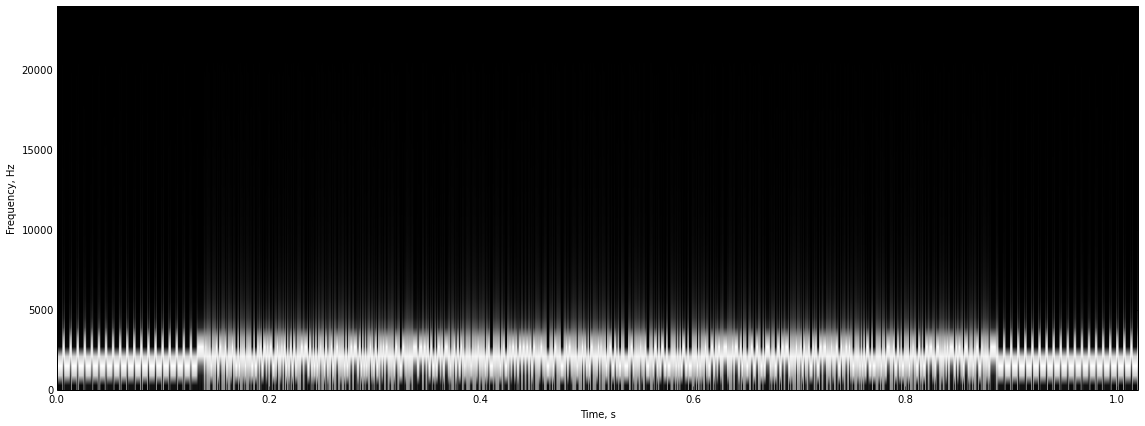

In [10]:
window = 80
fs = 48e3
myspectrogram_hann_ovlp(msg, window, fs, fc=0, dbf=30);

#### Task:

* Make sure the USB interface is connected and that the audio device numbers are correct. 
* Connect the interface you your radio input.
* Tune your radio to the EE123 APRS frequency: ch-113 on your radio, 433.550MHz, or to the APRS national frequency: 144.39MHz or Channel 117 on your radio. 
* Send the APRS packet through your radio. As always it is better to be outside in a high place. If you are near Cory Hall you should be OK, we have an APRS internet gateway in Cory, and there are several others in the area as well.
* Sometimes it is useful to send the packet twice, just to make sure it goes through. 
* Make sure your output volume and settings are the "Good choice" you calibrated in part I of the lab. This means you need to scale your audio by a factor <1.0 I use 0.2 
* Be very carefull that your radio is operating appropriately, i.e., not getting stuck in transmit etc. We do not wish to interfere with the APRS network!
* When using `play_audio` use the option `keydelay=0.3` This will add a delay of 300ms between keying and playing the sound. If it works for you, you can later reduce it, or use the default which is 100ms. The idea here is to let time for the power amplifier to ramp up before transmitting. Padding the packet also helps. 

** You do not need to identify yourself, since your packet already does identify you!**




In [15]:
p = pyaudio.PyAudio()

Qout = Queue.Queue()
ctrlQ = Queue.Queue()

Qout.put("KEYON")
Qout.put(msg*0.3)  # pick the gain that you calibrated in lab 5 part I
Qout.put("KEYOFF")
Qout.put("EOT")

play_audio( Qout ,ctrlQ ,p, 48000 , dusb_out, s, keydelay=0.3)

time.sleep(1)
p.terminate()

IOError: [Errno Internal PortAudio error] -9986

#### Important:

* Did you get an email? SMS? If so, try sending a position report and check in https://aprs.fi. You can also search for your callsign, and then press the raw-packets link. It will show you all the packets received from you in the last 48 hours.



#### Task:

* Please send an SMS message using the radio to (510) 859-4141, give your name and a comment. I've created this google voice account for this purpose. 

## Decodeing AX.25 and APRS Packets

Now that we know how to create AX.25 and APRS packets, know how to AFSK1200 modulate them, know how to demodulate AFSK1200 as well, we can move forward to receiving and decoding packets. By the end of that we will have a fully functioning communication system.

Download the file `ISSpkt.wav`. It contains an APRS packet I recorded on one of the ISS flybyes. Load it to your workspace using the function `wavread`, which we imported from `scipy.io`.
(ISSpkt.wav) 


In [22]:
# testfile = urllib.URLopener()
# testfile.context = ssl._create_unverified_context()
# testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/ISSpkt.wav", 'ISSpkt.wav')

In [13]:
fs,sig = wavread("ISSpkt.wav")

We will now automate the packet decoding by writing some functions that implement portions of the process.

* Run the function `nc_afsk1200Demod` on the ISS packet to get the demodulated "analog" NRZI
* Plot the signal. It should look like a signal with $\pm1$ switching!

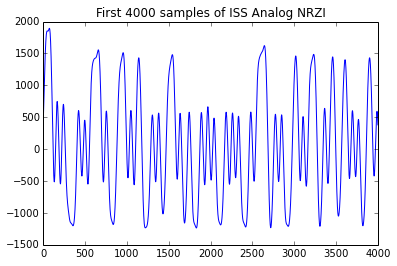

In [16]:
# your code
NRZIa = nc_afsk1200Demod(sig, fs=fs)
plot(NRZIa[:4000])
title('First 4000 samples of ISS Analog NRZI')

In [17]:
NRZIa

array([ 405.54842012,  445.01327098,  486.11510251, ...,  -76.58604843,
        -68.21410055,  -60.3288829 ])

### Decoding Bits from the Demodulated NRZI Signal

Once we demodulated the signal, the next task is to sample and look for packets in it! There are many ways to do so. We chose one similar to the DireWolfe implementation:

* Use the PLL to determine where to sample and get an output NRZI bitstream.
* Convert the NRZI to NRZ
* Search the bits and look for flags that indicate the existance of a packet. Of course, there may be many false detection. Hence, consider any flag is end of a packet, or beginning of a new one.
* Discard packets that are too short, or that the checksum does not match.

Below are several functions we wrote for you:

* `findPackets(bits)` - Searches a bitstream for possible valid packets
* `genfcs(bits)` - generates a checksum for validating packets
* `decodeAX25(bits)`  - Parses a packet bitstream into fields and decodes them

Study well these functions, and in particularly `findPackets(bits)`. You will need to modify it when performing stream processing.


In [8]:
def findPackets(bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        
        # Loop over bits
        while (n < len(bits)-7) :
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 8                    
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 200:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        packets.append(packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets

# function to generate a checksum for validating packets
def genfcs(bits):
    # Generates a checksum from packet bits
    fcs = ax25.FCS()
    for bit in bits:
        fcs.update_bit(bit)
    
    digest = bitarray.bitarray(endian="little")
    digest.frombytes(fcs.digest())

    return digest

# function to parse packet bits to information
def decodeAX25(bits):
    ax = ax25.AX25()
    ax.info = "bad packet"
    
    
    bitsu = ax25.bit_unstuff(bits[8:-8])
    
    if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
        #print("failed fcs")
        return ax
    
    bytes = bitsu.tobytes()
    ax.destination = ax.callsign_decode(bitsu[:56])
    source = ax.callsign_decode(bitsu[56:112])
    if source[-1].isdigit() and source[-1]!="0":
        ax.source = b"".join((source[:-1],'-',source[-1]))
    else:
        ax.source = source[:-1]
    
    digilen=0
    
    if bytes[14]=='\x03' and bytes[15]=='\xf0':
        digilen = 0
    else:
        for n in range(14,len(bytes)-1):
            if ord(bytes[n]) & 1:
                digilen = (n-14)+1
                break

#    if digilen > 56:
#        return ax
    ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8])
    ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    return ax

#### Task:

* Use the pll to find the sampling index of the analog NRZI
* Sample and convert to a bitarray (True is positive NRZI, False is negative NRZI)
* Convert the NRZI bits to NRZ
* Use `findPackets` to find packet in the bitstream

You should get this when decoding properly:

`1) |DEST:CQ     |SRC:RS0ISS |DIGI: |>ARISS - International Space Station|`

In [15]:
# your code here:
inds = PLL(NRZIa, fs=fs)
samples = NRZIa[inds]
bits = NRZI2NRZ(bitarray.bitarray((samples>0).tolist()))
packets = findPackets(bits)

NameError: name 'NRZIa' is not defined

In [20]:
inds

array([   18,    55,    92,   131,   168,   205,   242,   280,   317,
         354,   391,   428,   464,   501,   536,   573,   610,   647,
         684,   721,   758,   794,   831,   868,   905,   942,   979,
        1016,  1053,  1089,  1126,  1163,  1199,  1236,  1273,  1310,
        1346,  1383,  1419,  1456,  1493,  1530,  1567,  1604,  1641,
        1677,  1714,  1751,  1787,  1824,  1861,  1898,  1933,  1970,
        2007,  2044,  2080,  2117,  2154,  2191,  2227,  2264,  2301,
        2338,  2374,  2411,  2448,  2485,  2521,  2558,  2595,  2632,
        2669,  2706,  2743,  2780,  2816,  2853,  2889,  2926,  2963,
        3000,  3037,  3074,  3111,  3146,  3183,  3220,  3257,  3293,
        3330,  3367,  3403,  3440,  3477,  3514,  3551,  3588,  3625,
        3662,  3699,  3735,  3772,  3807,  3844,  3881,  3918,  3955,
        3992,  4028,  4065,  4101,  4138,  4175,  4212,  4249,  4286,
        4322,  4359,  4396,  4433,  4468,  4505,  4542,  4578,  4615,
        4651,  4688,

<Container object of 3 artists>

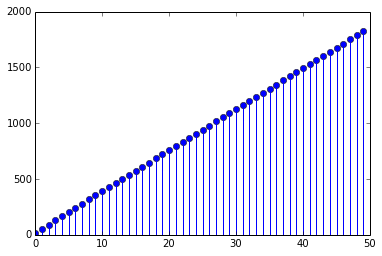

In [21]:
stem(inds[:50])

In [22]:
# code to display the packets
# for p in packets:
#     print p
# Iterate over all packets, print the valid ones
npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")


('1) |DEST:CQ     |SRC:RS0ISS |DIGI: |', '>ARISS - International Space Station', '|')


### Testing on more packets

Now, lets try our decoder on a noisy recording with many more packets. 

#### Task:
* Download the full recording of the pass, which is stored in `ISS.wav`. It's a 3min recording. It should decode in less than about a minute.  
* Process the signal and decode all the packets. My decoder decodes 24 packets successfully


In [19]:
# testfile = urllib.URLopener()
# testfile.context = ssl._create_unverified_context()
# testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/ISS.wav", 'ISS.wav')

In [21]:
fs, sig = wavread("ISS.wav")

# your code here:

# Get the analog signal.
NRZIa = nc_afsk1200Demod(sig, fs=fs)

# Find the sample inds.
inds = PLL(NRZIa, fs=fs)
samples = NRZIa[inds]

# Convert NRZI to NRZ
bits = NRZI2NRZ(bitarray.bitarray((samples>0).tolist()))

packets = findPackets(bits)

In [507]:
npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")

('1) |DEST:CQ     |SRC:RS0ISS |DIGI: |', '>ARISS - International Space Station', '|')
('2) |DEST:CQ     |SRC:N7HQB  |DIGI:RS0ISSp |', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r', '|')
('3) |DEST:CQ     |SRC:N7NEV  |DIGI:RS0ISSpWIDE2 2WIDE1 1 |', '>CQCQCQ\r', '|')
('4) |DEST:CQ     |SRC:N7HQB  |DIGI:RS0ISSp |', 'HELO VIA THE ISS\r', '|')
('5) |DEST:CQ     |SRC:K7RFK  |DIGI:RS0ISSp |', '\r', '|')
('6) |DEST:CQ     |SRC:K7RFK  |DIGI:RS0ISSp |', '\r', '|')
('7) |DEST:ARISS  |SRC:KF1BUZ |DIGI:RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 |', '=3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv\r', '|')
('8) |DEST:CQ     |SRC:K7RFK  |DIGI:RS0ISSp |', '\r', '|')
('9) |DEST:CQ     |SRC:N7NEV  |DIGI:RS0ISSpWIDE2 2WIDE1 1 |', '>from DM43\r', '|')
('10) |DEST:CQ     |SRC:N7HQB  |DIGI:RS0ISSp |', '=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!\r', '|')
('11) |DEST:CQ     |SRC:N7HQB  |DIGI:RS0ISSp |', 'HELLO VIA THE ISS\r', '|')
('12) |DEST:CQ     |SRC:K7RFK 

#### did you get 24 packets? yes i did


### Test Loop-back audio

The next step would be to test a loop-back in which we send audio through the USB audio device when its output and input are connected through a cable. To do so, 

#### Task:
* Carefully pull the USB audio device out of the USB hub
* Carefully disconnect the yellow jack that is connected to the microphone input to the USB. **Don't pull on the cable**, try to pull on the jack itself while holding the USB audio with the other hand.
* Look at the radio audio connector. It has two jacks. One is 3.5mm and the other 2.5mm. Stick the 3.5mm in the microphone slot of the USB audio. 
* Carefully put the USB audio back in place. You have now a loopback! You can use it later to test your real-time system.

This should look like this pictude below:

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/loopback.jpg" alt="loopback" style="width: 400px;"/></center>


#### Task:

* Generate 3 padded packets, with **different** information in them.
* Create the afsk1200 signal for each of the packets. 
* Start an audio recording thread that records from the USB audio and feeds a recording into a queue
* While recording, play one packet at a time, with some interval of 200-500ms between packets. 
* Decode the the packets from the recording
* Also, make a plot of the audio recording. Make sure its not saturated!

##### *****Alternative setup:  If you are working with a partner, connect your jack into your partner USB audio and vice versa. Try to pass the packets to your partner.

Tips:
* Use a thread only for recording, not for playing.
* Don't forget to kill the recording thread and exit the play function by sending "EOT" in the queue


In [12]:
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']

In [13]:
callsign = "KM6BJU"
Digi =b'WIDE1-1,WIDE2-1'
dest = "APCAL"

info1 = ":SMSGTE   :@4253508482 Hi Alex, this is Alex Walczak. This lab is the best yet!"
info2 = "=2759.16N/08655.30E[I'm on the top of the world"
info3 = ":ALL      : CQCQCQ I would like to talk to you!"

packet1 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info1,
		digipeaters=Digi.split(b','),
        )

packet2 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info2,
		digipeaters=Digi.split(b','),
        )

packet3 = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info3,
		digipeaters=Digi.split(b','),
        )

# AFSK encode msgs

prefix = bitarray.bitarray(tile([0,1,1,1,1,1,1,0],(20,)).tolist())

padded = int2bitarray(np.hstack([bits2nparray(prefix),bits2nparray(NRZ2NRZI(packet1.unparse())),bits2nparray(prefix)]), width=1)
msg1 = afsk1200(NRZ2NRZI(padded), fs=fs_usb)

padded = int2bitarray(np.hstack([bits2nparray(prefix),bits2nparray(NRZ2NRZI(packet2.unparse())),bits2nparray(prefix)]), width=1)
msg2 = afsk1200(NRZ2NRZI(padded), fs=fs_usb)

padded = int2bitarray(np.hstack([bits2nparray(prefix),bits2nparray(NRZ2NRZI(packet3.unparse())),bits2nparray(prefix)]), width=1)
msg3 = afsk1200(NRZ2NRZI(padded), fs=fs_usb)

# msg1 = afsk1200(packet1, fs=48e3)
# msg2 = afsk1200(packet2, fs=48e3)
# msg3 = afsk1200(packet3, fs=48e3)

In [1]:
# create an input output FIFO queues
# Qin = Queue.Queue()
Qout = Queue.Queue()

# create a control fifo to kill threads when done
cQin = Queue.Queue()
cQout = Queue.Queue()

# create a pyaudio object
p = pyaudio.PyAudio()

# get sampling rate from pyaudio
fs_usb = p.get_device_info_by_index(dusb_in)['defaultSampleRate']


# initialize a recording thread. 
# t_rec = threading.Thread(target = record_audio,   args = (Qin, cQin,p, fs_usb, dusb_out))

# initialize a playing thread. 

# start the recording and playing threads
# t_rec.start()

Qout.put(0.7*msg1)
Qout.put(0.7*msg2)
Qout.put(0.7*msg3)
cQout.put('EOT')

time.sleep(1)
play_audio(Qout, cQout, p, fs_usb, dusb_in)

# recv = []
# while not Qin.empty():
#     recv += list(Qin.get())
    
# Qin.put('EOT')
# time.sleep(3)

# with Qin.mutex:
#     Qin.queue.clear()
# with Qout.mutex:
#     Qout.queue.clear()
# with cQin.mutex:
#     cQin.queue.clear()
# with cQout.mutex:
#     cQout.queue.clear()

# p.terminate()

# NRZIa = nc_afsk1200Demod(recv, fs_usb)
# inds = PLL(NRZIa, fs=fs_usb)
# samples = NRZIa[inds]
# bits = NRZI2NRZ(bitarray.bitarray((samples>0).tolist()))
# packets = findPackets(bits)

NameError: name 'Queue' is not defined

In [ ]:
npack = 0
for pkt in packets:
        print(len(pkt))
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")

Congratulations,  you created a modem!


## Next.... We will move to stream processing to make it useful.

### Got up to here. Will work on the rest next.



In [119]:
NRZIa = nc_afsk1200Demod(msg, fs=48e3)
packets = []
inds = PLL(NRZIa, fs=48e3)
samples = NRZIa[inds]
bits = NRZI2NRZ(bitarray.bitarray((samples>0).tolist()))
packets = findPackets(bits)

npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                print(str(npack)+") |DEST:"+ax.destination[:-1]+" |SRC:"+ax.source + " |DIGI:"+ax.digipeaters+" |",ax.info,"|")

('1) |DEST:APCAL  |SRC:KM6BJU |DIGI:WIDE1 1WIDE2 1 |', ':SMSGTE   :@4253508482 Hi Alex, this is Alex Walczak. This lab is the best yet!', '|')
